In [ ]:
! wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
! tar -zxvf review_polarity.tar.gz

In [ ]:
filepath = '/content/'

# Clean the documents and store them to memory

In [ ]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from pickle import dump
import nltk
# nltk.download('stopwords')

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	# remove punctuation from each word
	tokens = [re_punc.sub('', w) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

# load all docs in a directory
def process_docs(directory, is_train):
	documents = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load the doc
		doc = load_doc(path)
		# clean doc
		tokens = clean_doc(doc)
		# add to list
		documents.append(tokens)
	return documents

# load and clean a dataset
def load_clean_dataset(is_train):
	# load documents
	neg = process_docs(filepath + 'txt_sentoken/neg', is_train)
	pos = process_docs(filepath + 'txt_sentoken/pos', is_train)
	docs = neg + pos
	# prepare labels
	labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
	return docs, labels

# save a dataset to file
def save_dataset(dataset, filename):
	dump(dataset, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load and clean all reviews
train_docs, ytrain = load_clean_dataset(True)
test_docs, ytest = load_clean_dataset(False)
# # save training datasets
save_dataset([train_docs, ytrain], 'train.pkl')
save_dataset([test_docs, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


train : test = 9 : 1

In [ ]:
print(type(train_docs))
print(len(train_docs))
print(len(ytrain))
print(len(test_docs))
print(len(ytest))

<class 'list'>
1800
1800
200
200


# Model Training with multi-channel

This allows the document to be
processed <u>at different resolutions or different n-grams</u> (groups of words) at a time, whilst the
model learns how to best integrate these interpretations.

We will define a
model with three input channels for processing <u>4-grams, 6-grams, and 8-grams</u> of movie review
text.

Three channels requires the input to be in a set of three, such as [X_train, X_train, X_train].


In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import concatenate

# load a clean dataset
def load_dataset(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# define the model
def define_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	model.summary()
	#plot_model(model, show_shapes=True, to_file='model.png')
	return model

# load training dataset
trainLines, trainLabels = load_dataset('train.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], array(trainLabels), epochs=7, batch_size=16)
# save the model
model.save('model.h5')

Max document length: 1380
Vocabulary size: 44277
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1380)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1380, 100)    4427700     ['input_1[0][0]']                
                                             

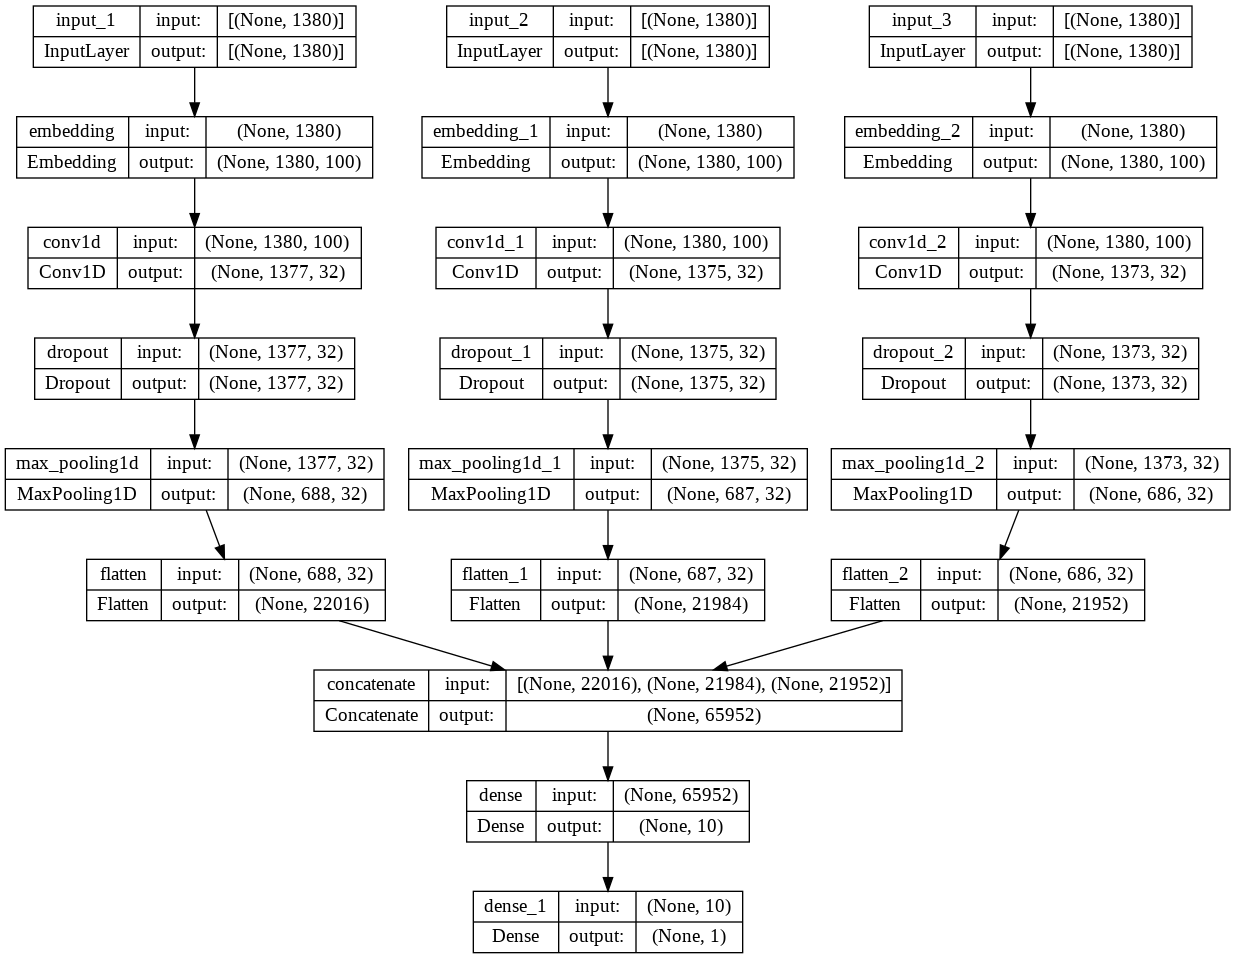

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True)

# Verify the model with Test documents

The test input should be in a set of three, like the train input.

In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model

# load a clean dataset
def load_dataset(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# load datasets
trainLines, trainLabels = load_dataset('train.pkl')
testLines, testLabels = load_dataset('test.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
# load the model
model = load_model('model.h5')
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX], array(trainLabels), verbose=0)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX], array(testLabels), verbose=0)
print('Test Accuracy: %.2f' % (acc*100))

Max document length: 1380
Vocabulary size: 44277
Train Accuracy: 100.00
Test Accuracy: 87.00


In [ ]:
def predict_sentiment(review, vocab, tokenizer, length, model):
	# clean review
	line = clean_doc(review)
	# encode and pad review
	padded = encode_text(tokenizer, [line], length)
	# predict sentiment
	yhat = model.predict([padded,padded,padded], verbose=0)
	# retrieve predicted percentage and label
	percent_pos = yhat[0,0]
	if  round(percent_pos) == 0:
		return (1-percent_pos), 'NEGATIVE'
	return percent_pos, 'POSITIVE'

text = 'This is a good movie'
percent, sentiment = predict_sentiment(text, tokenizer.word_index.keys(), tokenizer, length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [This is a good movie]
Sentiment: NEGATIVE (50.867%)


Not looking by a small doc, try a larger one with more than 1000 words.

In [ ]:
text = load_doc("/content/txt_sentoken/neg/cv003_12683.txt")
percent, sentiment = predict_sentiment(text, tokenizer.word_index.keys(), tokenizer, length, model)
print('Review: \nSentiment: %s (%.3f%%)' % (sentiment, percent*100))

Review: 
Sentiment: NEGATIVE (99.990%)
